 Data Sci Final Project

<b>Keyword<b> <br>
Recomendation Systen<br>
Customer Segmention

In [1]:
!pip install pandas-profiling
!pip install scikit-surprise
!pip install pandas-profiling

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import sys
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
import Recommenders as Recommenders
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import pairwise_distances
from collections import defaultdict


In [3]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from scipy.stats import norm
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import pandas_profiling

/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda3/lib/python3.6

### Index <br>
1. Data Preparation <br>
2. Exploratory Data Analysis <br>

### Data Preparation

In [4]:
# Set Current Directory
currentPath = os.getcwd()
subFolder = "/ml-100k/"
os.chdir(currentPath+subFolder)

### Helper Class and Function

In [5]:
def ImportFile(fileName,feature,sep,crange):
    if sep == None:
        sep = '|'
    if crange == None:
        df = pd.read_csv(fileName, sep=sep,names=feature,encoding='latin-1')
    else:
        df = pd.read_csv(fileName, sep=sep,names=feature,usecols=range(crange),encoding='latin-1')
    return df

In [6]:
userFeature = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
ratingFeature = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
genreFeature = ['genre']
moviesFeature = ['movie_id', 'title', 'release_date', 'video_release_date','imdb_url']

In [7]:
usersDf = ImportFile('u.user',userFeature,None,None)
print('total user : ',len(usersDf))
usersDf.info()
usersDf.head()

total user :  943
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
sex           943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [8]:
ratingDf = ImportFile('u.data',ratingFeature,'\t',4)
print('total user rating genre : ',len(ratingDf))
ratingDf.info()
ratingDf.head()

total user rating genre :  100000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id           100000 non-null int64
movie_id          100000 non-null int64
rating            100000 non-null int64
unix_timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
ratingDf.describe()

,user_id,movie_id,rating,unix_timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [10]:
genreDf = ImportFile('u.genre',['genre'],None,1)
print('total genre : ',len(genreDf))
ratingDf.info()
genreDf.head()

total genre :  19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id           100000 non-null int64
movie_id          100000 non-null int64
rating            100000 non-null int64
unix_timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


,genre
0,unknown
1,Action
2,Adventure
3,Animation
4,Children's


In [11]:
moviesFeature = moviesFeature+genreDf['genre'].values.tolist()
moviesDf = ImportFile('u.item',moviesFeature,None,len(moviesFeature))
moviesDf.info()
moviesDf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
movie_id              1682 non-null int64
title                 1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
imdb_url              1679 non-null object
unknown               1682 non-null int64
Action                1682 non-null int64
Adventure             1682 non-null int64
Animation             1682 non-null int64
Children's            1682 non-null int64
Comedy                1682 non-null int64
Crime                 1682 non-null int64
Documentary           1682 non-null int64
Drama                 1682 non-null int64
Fantasy               1682 non-null int64
Film-Noir             1682 non-null int64
Horror                1682 non-null int64
Musical               1682 non-null int64
Mystery               1682 non-null int64
Romance               1682 non-null int64
Sci-Fi                1682 non-null int64
Thriller 

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
moviesDf[moviesDf['title'] == 'Toy Story (1995)']['movie_id']

0    1
Name: movie_id, dtype: int64

### Data Cleansing

Convert release_date to date , year ,month

In [13]:
moviesDf['date'] = pd.to_datetime(moviesDf['release_date'])
moviesDf['year'] = (moviesDf['date'].dt.year)
moviesDf['month'] = (moviesDf['date'].dt.month)
moviesDf[['year','month']] = moviesDf[['year','month']].fillna(0)

In [14]:
moviesDf['month'] = moviesDf['month'].astype(int)
moviesDf['year'] = moviesDf['year'].astype(int)
moviesFeature = moviesFeature + ['date','year','month']

In [15]:
moviesDf[['movie_id','title','date','year','month']].head()

,movie_id,title,date,year,month
0,1,Toy Story (1995),1995-01-01,1995,1
1,2,GoldenEye (1995),1995-01-01,1995,1
2,3,Four Rooms (1995),1995-01-01,1995,1
3,4,Get Shorty (1995),1995-01-01,1995,1
4,5,Copycat (1995),1995-01-01,1995,1


Remove release year from title

In [16]:
newTitle = []
for c in moviesDf['title']:
    nc = c.split()
    title =''
    for i in range(0,len(nc)-1):
        if i != 0:
            title = title+' '+nc[i]
        else:
            title = title+nc[i]     
    newTitle.append(title)

In [17]:
moviesDf['title'] = newTitle
moviesDf[['movie_id','title','date','year','month']].head()

,movie_id,title,date,year,month
0,1,Toy Story,1995-01-01,1995,1
1,2,GoldenEye,1995-01-01,1995,1
2,3,Four Rooms,1995-01-01,1995,1
3,4,Get Shorty,1995-01-01,1995,1
4,5,Copycat,1995-01-01,1995,1


Drop unix_timestamp Column

In [18]:
#ratingDf.drop('unix_timestamp', axis=1, inplace=True)
#ratingDf.head()

In [19]:
moviesDf[moviesDf['year'] == 1995]

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,date,year,month
0,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995-01-01,1995,1
1,2,GoldenEye,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995-01-01,1995,1
2,3,Four Rooms,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995-01-01,1995,1
3,4,Get Shorty,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995-01-01,1995,1
4,5,Copycat,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995-01-01,1995,1
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao),01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,1995-01-01,1995,1
6,7,Twelve Monkeys,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,1,0,0,0,1995-01-01,1995,1
7,8,Babe,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,1995-01-01,1995,1
8,9,Dead Man Walking,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,1995-01-01,1995,1
10,11,Seven (Se7en),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Se7en%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995-01-01,1995,1


In [20]:
moviesDf[moviesDf['year'] == 0]

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,date,year,month
266,267,,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,NaT,0,0


In [21]:
moviesDf.drop(moviesDf.index[266],inplace=True)
print('remove 266')

remove 266


In [22]:
len(moviesDf[moviesDf['year'] == 0])

0

## Exploratory Data Analysis

In [23]:
temp = moviesDf[['movie_id', 'year']].groupby('year')
year = temp.year.first()
amt = temp.movie_id.nunique()
amt

year
1922      1
1926      1
1930      1
1931      1
1932      1
1933      2
1934      4
1935      4
1936      2
1937      4
1938      3
1939      7
1940      8
1941      5
1942      2
1943      4
1944      5
1945      4
1946      5
1947      5
1948      3
1949      4
1950      7
1951      5
1952      3
1953      2
1954      7
1955      5
1956      4
1957      8
       ... 
1969      4
1970      3
1971      7
1972      3
1973      4
1974      8
1975      6
1976      5
1977      4
1978      4
1979      9
1980      8
1981     12
1982     13
1983      5
1984      8
1985      7
1986     15
1987     13
1988     11
1989     15
1990     24
1991     22
1992     37
1993    126
1994    214
1995    219
1996    355
1997    286
1998     65
Name: movie_id, Length: 71, dtype: int64

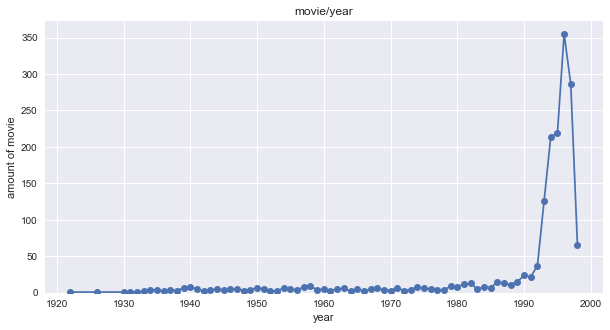

In [24]:
temp = moviesDf[['movie_id', 'year']].groupby('year')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(temp.year.first(), temp.movie_id.nunique(), marker="o", color='b')
ax1.set_ylim(0,)
ax1.set_xlabel('year')
ax1.set_ylabel('amount of movie'); 
#ax2.set_ylabel('Number of ratings')
plt.title('movie/year')
plt.show()

แสดงการกระจายของ User ตามช่วงอายุ

Text(0,0.5,'User Amount')

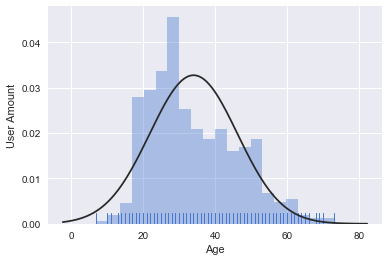

In [25]:
sns.set_color_codes("muted")
sns.distplot(usersDf.age,bins=20,fit=norm,kde=False,rug=True,color="b")
plt.xlabel('Age');
plt.ylabel('User Amount')

นับจำนวน User ในแต่ละอาชีพ

In [26]:
occupationDict = dict()
occupations = usersDf['occupation'].unique()
for occupation in occupations:
    occupationDict[occupation] = len(usersDf.loc[usersDf['occupation'] == occupation])

แสดงจำนวน User โดยแยกตามอาชีพ

In [27]:
occupationDf = pd.DataFrame.from_dict(occupationDict, orient = 'index')
occupationDf.columns = ['amount']
print('user ',occupationDf.sum())
occupationDf.sort_values('amount')

user  amount    943
dtype: int64


,amount
doctor,7
homemaker,7
none,9
lawyer,12
salesman,12
retired,14
healthcare,16
entertainment,18
marketing,26
technician,27


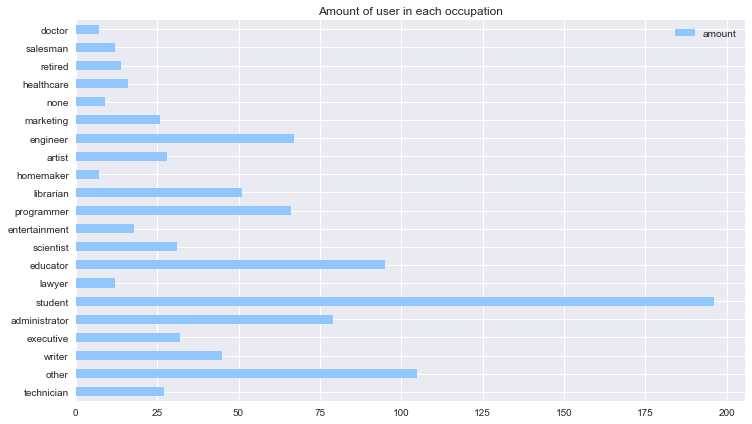

In [28]:
fig, ax = plt.subplots()
sns.set_color_codes("pastel")
occupationDf.plot.barh(y='amount',ax=ax,figsize=(12, 7),color='b',
                      title='Amount of user in each occupation')

In [29]:
sexDict = dict()
sexs = usersDf['sex'].unique()
for sex in sexs:
    sexDict[sex] = len(usersDf.loc[usersDf['sex'] == sex])
    
sexDf = pd.DataFrame.from_dict(sexDict, orient = 'index')
sexDf.columns = ['amount']
print('user ',sexDf.sum())
sexDf

user  amount    943
dtype: int64


,amount
M,670
F,273


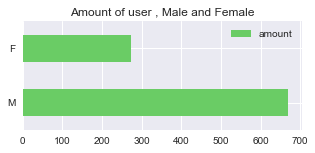

In [30]:
fig, ax = plt.subplots()
sns.set_color_codes("muted")
sexDf.plot.barh(y='amount',ax=ax,figsize=(5,2),color='g',
                      title='Amount of user , Male and Female')

In [31]:
usersDf.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [32]:
df_test = usersDf[usersDf['occupation'] == 'technician']['age']

In [33]:
df_test

0      24
3      24
43     26
76     30
142    42
196    55
243    28
293    34
310    32
324    48
440    50
455    24
457    47
487    48
544    27
669    30
714    21
716    24
717    42
737    35
738    35
789    27
811    22
831    24
849    34
888    24
937    38
Name: age, dtype: int64

In [34]:
#usersDf.iloc[:,3:4].head()

In [35]:
#pd.get_dummies(usersDf.iloc[:,3:4])

In [36]:
g = usersDf.groupby(['occupation','sex']).count()
g[0:4]

user_id  age  zip_code
occupation    sex                        
administrator F         36   36        36
              M         43   43        43
artist        F         13   13        13
              M         15   15        15

Text(0.5,1,'Ratings Distribution')

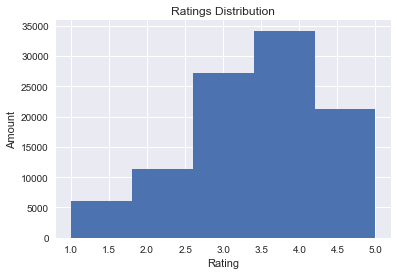

In [37]:
ratingDf.rating.plot.hist(bins=5)
plt.ylabel('Amount')
plt.xlabel('Rating')
plt.title("Ratings Distribution")

In [ ]:
temp = ratingDf[['user_id','rating']].groupby('user_id').mean()
temp.plot.hist(bins=50,color='orange',edgecolor='black')
plt.ylabel('Amount')
plt.xlabel('Rating')
plt.title("Ratings Distribution")

Text(0.5,1,'Ratings Distribution')

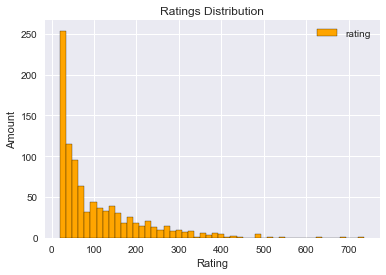

In [39]:
temp = ratingDf[['user_id','rating']].groupby('user_id').count()
temp.plot.hist(bins=50,color='orange',edgecolor='black')
plt.ylabel('Amount')
plt.xlabel('Rating')
plt.title("Ratings Distribution")

In [40]:
ratingDf.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [41]:
movieRatingDf = pd.merge(pd.merge(moviesDf, ratingDf),usersDf)
len(movieRatingDf)

99991

In [42]:
movieRatingDf.columns

Index(['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'date', 'year', 'month', 'user_id', 'rating', 'unix_timestamp', 'age',
       'sex', 'occupation', 'zip_code'],
      dtype='object')

In [43]:
movie_grouped = movieRatingDf.groupby(['title']).agg({'user_id': 'count'}).reset_index()
sum_rate = movieRatingDf.groupby(['title']).agg({'rating': 'sum'}).reset_index()
median_rate = movieRatingDf.groupby(['title']).agg({'rating': 'median'}).reset_index()
mean_rate = movieRatingDf.groupby(['title']).agg({'rating': 'mean'}).reset_index()
movie_grouped['totalscore'] = sum_rate['rating']
movie_grouped['rating_mean'] = mean_rate['rating']
movie_grouped['rating_median'] = median_rate['rating']
#movie_grouped['percentage']  = movie_grouped['rating'].div(movie_grouped['totalscore'])*100
movie_grouped = movie_grouped.rename(index=str, columns={"rating": "totaluser"})
movie_grouped.sort_values(['rating_median'], ascending=False)

,title,user_id,totalscore,rating_mean,rating_median
1129,Pather Panchali,8,37,4.625000,5.0
506,Faust,5,21,4.200000,5.0
1120,Paradise Lost: The Child Murders at Robin Hood...,20,81,4.050000,5.0
1467,They Made Me a Criminal,1,5,5.000000,5.0
85,Aparajito,7,25,3.571429,5.0
30,Aiqing wansui,1,5,5.000000,5.0
1214,Rear Window,209,917,4.387560,5.0
1394,Star Wars,583,2541,4.358491,5.0
1171,Prefontaine,3,15,5.000000,5.0
1495,Titanic,350,1486,4.245714,5.0


### Recomendation by Popularity

In [44]:
train_data, test_data = train_test_split(movieRatingDf, test_size = 0.20, random_state=0)

In [45]:
train_data_grouped = train_data.groupby('title').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_sort = train_data_grouped.sort_values(['score', 'title'], ascending = [0,1])
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

topN = 10
popularityList = train_data_sort.head(topN)
popularityList

,title,score,rank
1372,Star Wars,457,1.0
489,Fargo,410,2.0
327,Contact,398,3.0
1212,Return of the Jedi,394,4.0
1260,Scream,382,5.0
451,"English Patient, The",380,6.0
845,Liar Liar,366,7.0
1496,Toy Story,363,8.0
32,Air Force One,341,9.0
731,Independence Day (ID4),341,10.0


In [46]:
recommender1 = Recommenders.popularity_recommender_py()
recommender1.create(train_data, 'user_id', 'title')

In [47]:
recommender1.recommend(123)

,user_id,title,score,Rank
1372,123,Star Wars,457,1.0
489,123,Fargo,410,2.0
327,123,Contact,398,3.0
1212,123,Return of the Jedi,394,4.0
1260,123,Scream,382,5.0
451,123,"English Patient, The",380,6.0
845,123,Liar Liar,366,7.0
1496,123,Toy Story,363,8.0
32,123,Air Force One,341,9.0
731,123,Independence Day (ID4),341,10.0


In [48]:
recommender1.recommend(124)

,user_id,title,score,Rank
1372,124,Star Wars,457,1.0
489,124,Fargo,410,2.0
327,124,Contact,398,3.0
1212,124,Return of the Jedi,394,4.0
1260,124,Scream,382,5.0
451,124,"English Patient, The",380,6.0
845,124,Liar Liar,366,7.0
1496,124,Toy Story,363,8.0
32,124,Air Force One,341,9.0
731,124,Independence Day (ID4),341,10.0


### Collaborative Filtering

In [88]:
pivotRatingDf = ratingDf.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
pivotRatingDf.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
1,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Sparsity

Text(52,0.5,'movie_id')

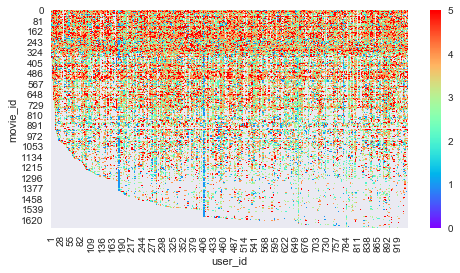

In [90]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.heatmap(pivotRatingDf, 0,5, cmap='rainbow')
ax.set_xlabel('user_id')
ax.set_ylabel('movie_id')

In [92]:
pivotRatingDf.fillna(0,inplace=True)
pivotRatingDf.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(52,0.5,'movie_id')

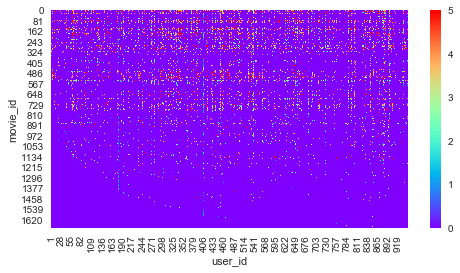

In [93]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.heatmap(pivotRatingDf, 0,5, cmap='rainbow')
ax.set_xlabel('user_id')
ax.set_ylabel('movie_id')

In [52]:
# Sparsity
print(pivotRatingDf.shape)
zero_sample = (pivotRatingDf == 0).astype(int).sum(axis=1).sum()
samples = pivotRatingDf.shape[0] * pivotRatingDf.shape[1]
print('total zero rating : ',zero_sample)
print('total sample : ',samples)

print('Sparsity',(zero_sample * 100)/samples)


(1682, 943)
total zero rating :  1486126
total sample :  1586126
Sparsity 93.69533063577546


In [53]:
def getCosineSimilarity(firstProdeucIndex,secondProductIndex):    
    sumdotAB = 0
    sumMagA = 0
    sumMagB = 0  
    for i in range(0,len(pivotRatingDf.T)):
        a = pivotRatingDf.T.iloc[:,firstProdeucIndex].values[i]
        b = pivotRatingDf.T.iloc[:,secondProductIndex].values[i]

        sumdotAB = sumdotAB + np.dot(a,b) 
        
        sumMagA = sumMagA + np.dot(a,a) 
        sumMagB = sumMagB + np.dot(b,b) 

    cosine_similarity = sumdotAB / (math.sqrt(sumMagA)*math.sqrt(sumMagB))
    return cosine_similarity

In [54]:
print(getCosineSimilarity(1,10))
print(getCosineSimilarity(1,50))
print(getCosineSimilarity(1,100))
print(getCosineSimilarity(1,459))

0.468505717847
0.342136408472
0.344402639839
0.0851805601499


In [55]:
similarityMatrix = 1 - pairwise_distances( pivotRatingDf.as_matrix(), metric="correlation" )
finalRatingsMatrix = pd.DataFrame(similarityMatrix)
finalRatingsMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,1.000000,0.234595,0.193362,0.226213,0.128840,0.015113,0.347354,0.254490,0.209502,0.104655,...,0.018215,-0.029676,-0.029676,-0.029676,0.018215,-0.029676,-0.029676,-0.029676,0.034179,0.034179
1,0.234595,1.000000,0.190649,0.409044,0.240712,0.030062,0.220022,0.206020,0.077894,0.072906,...,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,0.071415,0.071415
2,0.193362,0.190649,1.000000,0.227849,0.141368,0.065347,0.258855,0.078636,0.146181,0.079608,...,-0.009764,-0.009764,-0.009764,-0.009764,0.023964,-0.009764,-0.009764,-0.009764,-0.009764,0.091421
3,0.226213,0.409044,0.227849,1.000000,0.237298,0.021878,0.295489,0.352800,0.229922,0.138220,...,-0.016619,-0.016619,0.088984,0.088984,0.025622,-0.016619,-0.016619,-0.016619,0.046743,0.067863
4,0.128840,0.240712,0.141368,0.237298,1.000000,-0.008594,0.205289,0.145866,0.142541,-0.033746,...,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,0.088618


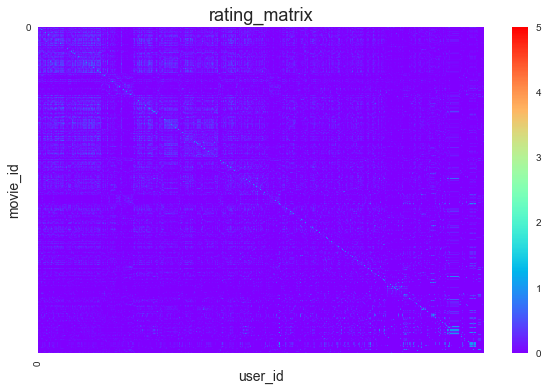

In [69]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax = sns.heatmap(finalRatingsMatrix, 0,5, cmap='rainbow')

ax.set_title('rating_matrix', fontsize=18)

ax.set_xlabel('user_id', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels()[::100])
ax.set_xticks(ax.get_xticks()[::100])

ax.set_ylabel('movie_id', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels()[::200])
ax.set_yticks(ax.get_yticks()[::200])

plt.show()


In [56]:
recommender2 = Recommenders.item_similarity_recommender_py()
recommender2.create(train_data, 'user_id', 'title')

In [57]:
user_id = 99
user_items = recommender2.get_user_items(user_id)
#for user_item in user_items:
#    print(user_item)
    
userItemDF = pd.DataFrame({'Movie':user_items})
userItemDF

,Movie
0,Batman
1,Some Folks Call It a Sling Blade
2,"Time to Kill, A"
3,"Birdcage, The"
4,Joe's Apartment
5,Black Sheep
6,Sabrina
7,Leaving Las Vegas
8,William Shakespeare's Romeo and Juliet
9,Apt Pupil


In [58]:
user_id = 99
recommender2.recommend(user_id)

No. of unique movies for the user: 111
no. of unique movies in the training set: 1634
Non zero values in cooccurence_matrix :153914


,user_id,movie,score,rank
0,99,Back to the Future,0.190443,1
1,99,Independence Day (ID4),0.188023,2
2,99,E.T. the Extra-Terrestrial,0.182041,3
3,99,Groundhog Day,0.180091,4
4,99,Top Gun,0.179896,5
5,99,True Lies,0.179031,6
6,99,"Terminator, The",0.178607,7
7,99,Terminator 2: Judgment Day,0.178374,8
8,99,Jurassic Park,0.177159,9
9,99,Aliens,0.177037,10


### Matrix Factorization

KNN Base 

In [59]:
reader = Reader(rating_scale=(1, 5))
#data = Dataset.load_from_df(ratingDf[['user_id', 'movie_id', 'rating']], reader)
data = Dataset.load_builtin('ml-100k')
algorithms = KNNBasic()

trainset = data.build_full_trainset()
result = algorithms.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [60]:
def getTopN(predictions,n):
   
    topN = defaultdict(list)
    for user_id, item_id, true_r, est, _ in predictions:
        topN[user_id].append((item_id, est))

    for user_id, user_ratings in topN.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        topN[user_id] = user_ratings[:n]

    return topN


In [61]:
testset = trainset.build_anti_testset()
predictions = algorithms.test(testset)

In [62]:
recList = getTopN(predictions, n=10)
for user_id, user_ratings in recList.items():
    print(user_id, [item_id for (item_id, _) in user_ratings])

196 ['1189', '1500', '814', '1536', '1599', '1653', '1467', '1122', '1201', '1293']
186 ['1189', '1500', '814', '1536', '1599', '1653', '1122', '1201', '1293', '1467']
22 ['1189', '1500', '814', '1536', '1293', '1599', '1656', '1653', '1467', '1122']
244 ['1189', '1500', '814', '1536', '1599', '1653', '1122', '1201', '1293', '483']
166 ['1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201', '1189']
298 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1122', '1201', '1467']
115 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201']
253 ['1189', '814', '1536', '1293', '1599', '1653', '1122', '1201', '1500', '1467']
305 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201']
6 ['1500', '814', '1536', '1293', '1653', '1467', '1122', '1201', '1189', '1599']
62 ['1189', '1500', '814', '1536', '1599', '1653', '1467', '1122', '1201', '1293']
286 ['1189', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201', '1500

17 ['1306', '1500', '814', '1536', '1599', '1653', '1467', '1122', '1201', '1189']
313 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201']
53 ['1189', '1500', '814', '1536', '1293', '1599', '1656', '1653', '1467', '1122']
124 ['1189', '1500', '1463', '814', '1536', '1599', '1656', '1467', '1122', '1201']
149 ['1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201', '1189']
176 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201']
106 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201']
312 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1122', '1201', '1467']
175 ['1189', '1500', '1463', '814', '1536', '1599', '1656', '1467', '1122', '1201']
153 ['1189', '814', '1536', '1293', '1599', '1656', '1653', '1467', '1122', '1201']
220 ['1189', '1500', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201']
143 ['1189', '814', '1536', '1293', '1599', '1653', '1467', '1122', '1201', '1

In [63]:
recList[2][0][1]

IndexError: list index out of range

In [ ]:
def getItemName(user_id,rec):
    for i in range(0,len(rec[user_id])):
        item = rec[user_id][i][0]
        score = rec[user_id][i][1]
        title = moviesDf[moviesDf.movie_id == item]['title'].values[0]
        print(title)

    

In [ ]:
getItemName(500,recList)

In [ ]:
algorithms = SVD()
result = cross_validate(algorithms, data, cv=5)
pd.DataFrame.from_dict(result)

In [ ]:
#usersDf[usersDf['occupation'] == 'technician']['age']

In [ ]:
algorithms = SVDpp()
result = cross_validate(algorithms, data, cv=5)
pd.DataFrame.from_dict(result)

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratingDf[['user_id', 'movie_id', 'rating']], reader)
algorithms = SVD()
result = cross_validate(algorithms, data, cv=5)

In [ ]:
pd.DataFrame.from_dict(result)